# <center>Online Retail Clustering</center>

### Agenda : 
We are required to cluster the customers using different attributes shared in the data
### Data used : 
We have used the data to define the frequency of purchase, recency of purchase and amount of purchase to cluster the customers

### This notebook has been created after multiple iteration:<br>
1. Iteration 1 : Implemented the K means algorithm using python
2. Iteration 2 : Created other data attributes which may help in Clustering
3. Iteration 3 : Scaled the data to improve the clustering technique
4. Iteration 4 : Lastly, realised there are anomalies and so implemented IQR to eliminate iteration


## Importing libraries

In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

## Reading dataframe

In [230]:
# Pulling invoice data
df_retail = pd.read_csv(r'C:\Users\Prashant\Documents\Machine Learing Workspace\Online-Retail-Clustering\.gitignore\OnlineRetail.csv')

In [231]:
df_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


## Null value treatment

In [232]:
df_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [233]:
print('Number of na in customer id =' ,df_retail['CustomerID'].isna().sum())
print('Number of null in customer id =' ,df_retail['CustomerID'].isnull().sum())

Number of na in customer id = 135080
Number of null in customer id = 135080


In [234]:
df_retail['CustomerID'].fillna(0,inplace=True)
df_retail['Description'].fillna('No description',inplace=True)
df_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  541909 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   541909 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## Creating attributes for clustering

In [235]:
# First attribute : Total amount paid
df_retail['Amount'] = df_retail['Quantity'] * df_retail['UnitPrice']
df_amount = df_retail.groupby(['CustomerID'],as_index=False)["Amount"].sum()
df_amount.head()

,CustomerID,Amount
0,0.0,1447682.12
1,12346.0,0.00
2,12347.0,4310.00
3,12348.0,1797.24
4,12349.0,1757.55


In [236]:
# Second attribute : Purchase recency

# UDF to convert string to datetime
def convertDate(x):
    conv_date = datetime.datetime.strptime(x, '%d-%m-%Y %H:%M')
    return conv_date

In [237]:
# UDF to split date and pick out recent purchase days 
def splitDate(y):
    y = str(y)
    num_days = y.split()[0]
    num_days = int(num_days)
    return num_days

In [238]:
df_retail['InvoiceDate'] = df_retail.loc[:,'InvoiceDate'].apply(convertDate)

In [239]:
max_date = df_retail['InvoiceDate'].max()
df_retail['Recent_purchase_days'] = max_date - df_retail['InvoiceDate']

In [240]:
df_retail['Recent_purchase_days'] = df_retail['Recent_purchase_days'].apply(splitDate)
df_rec_purch = df_retail.groupby(['CustomerID'],as_index=False)["Recent_purchase_days"].min()
df_rec_purch.head()

,CustomerID,Recent_purchase_days
0,0.0,0
1,12346.0,325
2,12347.0,1
3,12348.0,74
4,12349.0,18


In [241]:
# Attribute : Frequency of purchase
df_purchase_freq = df_retail.groupby(['CustomerID'],as_index=False)["InvoiceNo"].count()
df_purchase_freq.rename(columns={'CustomerID':'CustomerID','InvoiceNo':'PurchaseCount'},inplace=True)
df_purchase_freq.head()

,CustomerID,PurchaseCount
0,0.0,135080
1,12346.0,2
2,12347.0,182
3,12348.0,31
4,12349.0,73


## Create Analytical data set for the clustering model

In [242]:
df_amt_purch = df_amount.merge(df_rec_purch,how='left',on=['CustomerID'])
df_model_inp = df_amt_purch.merge(df_purchase_freq,how='left',on=['CustomerID'])
df_model_inp.head()

,CustomerID,Amount,Recent_purchase_days,PurchaseCount
0,0.0,1447682.12,0,135080
1,12346.0,0.00,325,2
2,12347.0,4310.00,1,182
3,12348.0,1797.24,74,31
4,12349.0,1757.55,18,73


## Performing scaling on the analytical data set

In [243]:
from sklearn.preprocessing import StandardScaler
# define standard scaler
scaler = StandardScaler()
# transform data
df_scalar = scaler.fit_transform(df_model_inp.iloc[:,1:4])

df_scalar1 = pd.DataFrame(df_scalar)
df_scalar1.columns = ['Amount' , 'Frequency' , 'Recency']
df_scalar1.head()

,Amount,Frequency,Recency
0,61.892754,-0.903471,65.696532
1,-0.095447,2.322278,-0.059351
2,0.089103,-0.893545,0.028273
3,-0.018491,-0.168992,-0.045234
4,-0.020190,-0.724814,-0.024789


## Anomaly detection

In [244]:
# UDF to determine outliers in data for all the columns
def viewDistribution(df):
    sns.boxplot(data=df)
    plt.xticks(rotation=90)
    plt.show

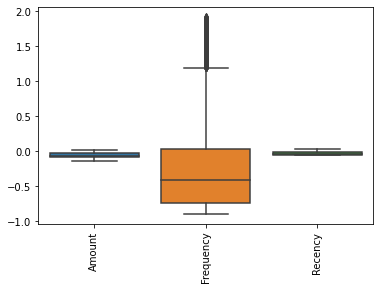

In [245]:
# INSIGHTS: There are outliers in amount and frequency column
viewDistribution(data)

In [246]:
# UDF to remove outlier
def remove_outlier_IQR(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    return df_final

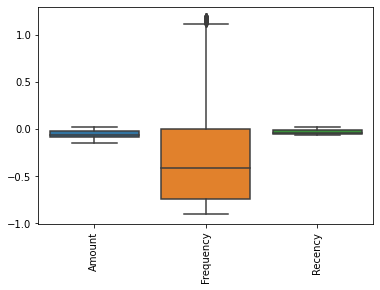

In [247]:
# Removed the anomalies in all the columns
df_IQR = remove_outlier_IQR(data)
df_IQR.fillna(0,inplace=True)
viewDistribution(df_IQR)

## Mathematical implementation of K means clustering techinique
1.Pick K points as the initial centroids from the data set, either randomly or the first K.<br>
2.Find the Euclidean distance of each point in the data set with the identified K points — cluster centroids.<br>
3.Assign each data point to the closest centroid using the distance found in the previous step.<br>
4.Find the new centroid by taking the average of the points in each cluster group.<br>
5.Repeat iteration till the centroids don’t change.<br>


In [248]:
# Defining centroids
k = 5

# Filtering the columns required for clustering
data = df_IQR.iloc[:,0:3]
data.head()

,Amount,Frequency,Recency
0,0.000000,-0.903471,0.000000
1,-0.095447,0.000000,-0.059351
2,0.000000,-0.893545,0.000000
3,-0.018491,-0.168992,-0.045234
4,-0.020190,-0.724814,-0.024789


In [249]:
# Storing the sample dataframe to determine the number of centroids
k_means = (data.sample(k, replace=False))    # store current means
k_means2 = pd.DataFrame()                    # store previous means
clusters = pd.DataFrame()    

In [250]:
while not k_means2.equals(k_means):
    # distance matrix (euclidean distance)
    cluster_count = 0
    for idx, k_mean in k_means.iterrows():
        clusters[cluster_count] = (data[k_means.columns] - np.array(k_mean)).pow(2).sum(1).pow(0.5)
        cluster_count += 1

    # update cluster
    data['MDCluster'] = clusters.idxmin(axis=1)

    # store previous cluster
    k_means2 = k_means
    k_means = pd.DataFrame()
    k_means_frame = data.groupby('MDCluster').agg(np.mean)
    k_means[k_means_frame.columns] = k_means_frame[k_means_frame.columns]

ipykernel_launcher:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [251]:
data.head()

,Amount,Frequency,Recency,MDCluster
0,0.000000,-0.903471,0.000000,0
1,-0.095447,0.000000,-0.059351,1
2,0.000000,-0.893545,0.000000,0
3,-0.018491,-0.168992,-0.045234,2
4,-0.020190,-0.724814,-0.024789,0


## Plotting clusters 

C:\Users\Prashant\.virtualenvs\online-retail-cluster\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



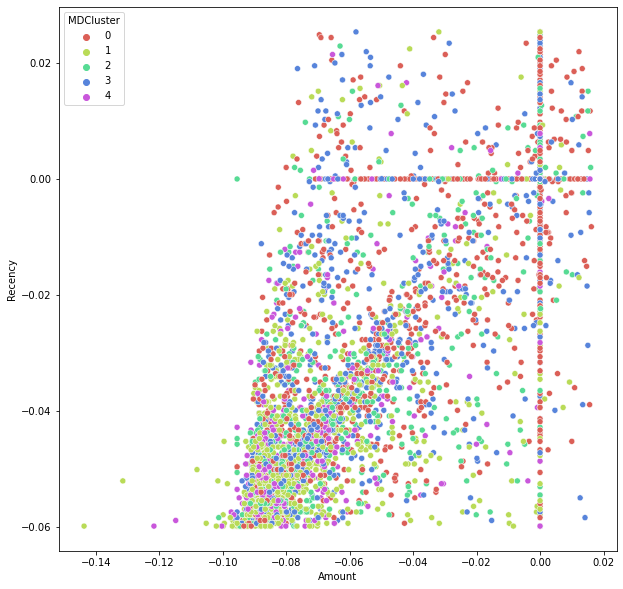

In [252]:
# plotting
import seaborn as sns
plt.figure(figsize=(10,10))
sns.scatterplot(data['Amount'] ,data['Recency'] , hue = data['MDCluster'], palette = sns.color_palette('hls',5))
plt.show()